In [1]:
import sys 
sys.path.append('..')
from   tools.utils import convert_tensor_to_numpy
from data_util.dataset import Data
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk

/home/l.estacio/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_sample_data(sample, slide=80, save_path=None):
    
    voxel1 = convert_tensor_to_numpy(sample['voxel1'])
    print(voxel1.shape)
    voxel2 = convert_tensor_to_numpy(sample['voxel2'])
    segmentation1 = convert_tensor_to_numpy(sample['segmentation1'])
    segmentation2 = convert_tensor_to_numpy(sample['segmentation2'])
    kps_i = np.zeros(voxel1[:, :, slide].shape)
    kps_e = np.zeros(voxel2[:, :, slide].shape)
    
    # Uncomment if you need to visualize keypoints
    kps_i_coords = convert_tensor_to_numpy(sample['kps1'])
    kps_e_coords = convert_tensor_to_numpy(sample['kps2'])
    for kp in kps_i_coords[kps_i_coords[:, 2] == slide]:
        kps_i[int(kp[1]), int(kp[0])] = 1
    for kp in kps_e_coords[kps_e_coords[:, 2] == slide]:
        kps_e[int(kp[1]), int(kp[0])] = 1
    
    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    axs[0, 0].imshow(voxel1[:, :, slide], cmap='gray') # slide shouls be the last axis
    axs[0, 1].imshow(voxel2[:, :, slide], cmap='gray')
    axs[1, 0].imshow(segmentation1[:, :, slide], cmap='gray')
    axs[1, 1].imshow(segmentation2[:, :, slide], cmap='gray')
    # comment if you do not need to visualize keypoints
    axs[2, 0].imshow(kps_i, cmap='gray')
    axs[2, 1].imshow(kps_e, cmap='gray')
    
    axs[0, 0].axis('off')
    axs[0, 1].axis('off')
    axs[1, 0].axis('off')
    axs[1, 1].axis('off')
    axs[2, 0].axis('off')
    axs[2, 1].axis('off')
    
    plt.tight_layout()
    
    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()

20
(192, 192, 208)


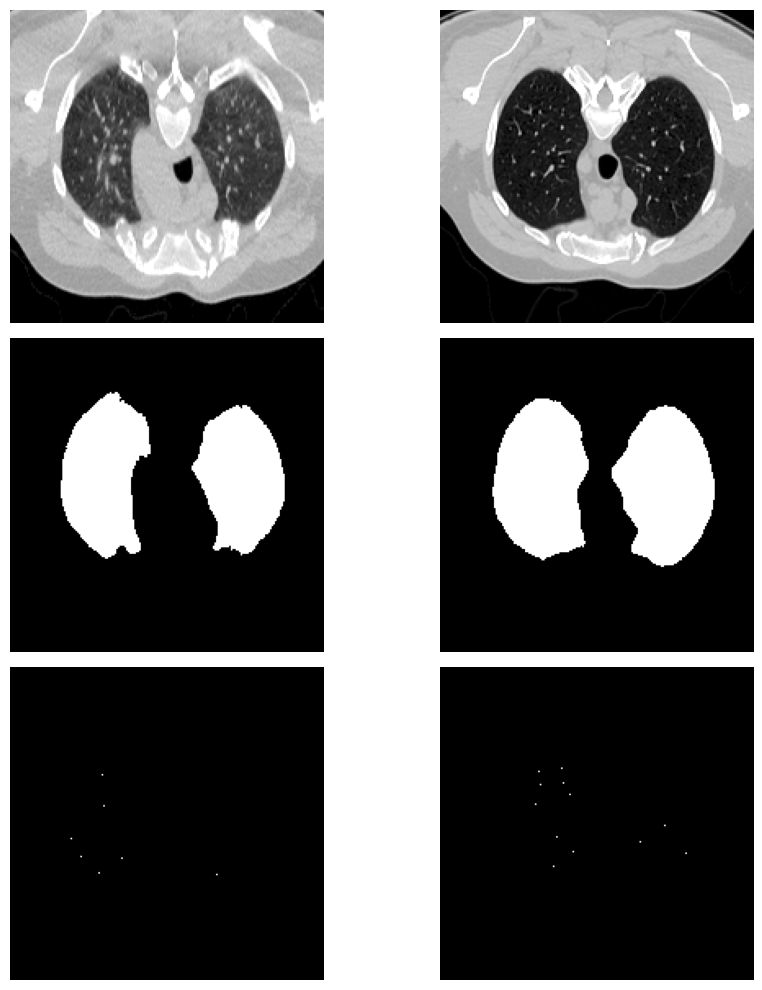

In [3]:
data_file = '/data/groups/beets-tan/l.estacio/lung_data/LungCT/LungCT_dataset.json'
root_dir  = '/data/groups/beets-tan/l.estacio/lung_data/LungCT/'
data      = Data(data_file, root_dir=root_dir, mode='train')
sample_id = 1
sample    = data[sample_id]
print(len(data))
plot_sample_data(sample, slide=150)

In [4]:
from tools.utils import convert_tensor_to_numpy
from metrics.losses import compute_TRE
fixed_kps  = sample['kps1'][:,:]
moving_kps = sample['kps2'][:,:]
fixed_img  = sample['img1']
moving_img = sample['img2']
print(type(moving_kps), type(fixed_kps), type(moving_img))
moving_kps = convert_tensor_to_numpy(moving_kps)
fixed_kps  = convert_tensor_to_numpy(fixed_kps)
print(type(moving_kps), type(fixed_kps), type(moving_img))
print('Image Spacing',compute_TRE(moving_kps, fixed_kps, moving_img.GetSpacing()))
print('Spacing [1.75, 1.25, 1.75]', compute_TRE(moving_kps, fixed_kps, [1.75, 1.25, 1.75]))
print('Spacing [1, 1, 1]', compute_TRE(moving_kps, fixed_kps, [1., 1., 1.]))

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'SimpleITK.SimpleITK.Image'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'SimpleITK.SimpleITK.Image'>
Image Spacing (16.16545165692608, 6.438226863907224)
Spacing [1.75, 1.25, 1.75] (16.16545165692608, 6.438226863907224)
Spacing [1, 1, 1] (10.58059525391295, 4.092258162760994)


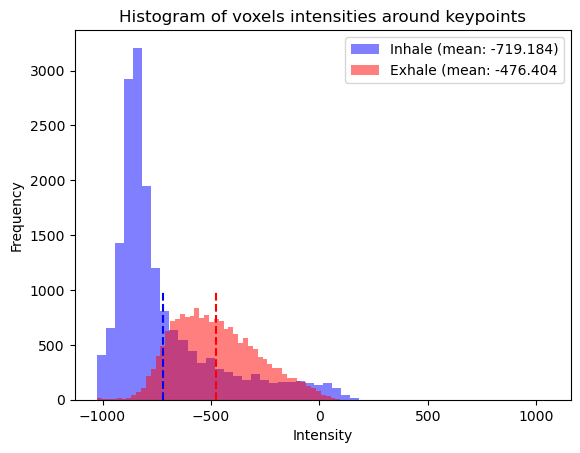

In [5]:
fixed_image  = sitk.ReadImage(sample['img1_path'])
moving_image = sitk.ReadImage(sample['img2_path'])
mov_voxels = []
fix_voxels = []


for p in fixed_kps:
    fix_voxels.extend(fixed_image[int(p[0])-1:int(p[0])+1, int(p[1])-1:int(p[1])+1, int(p[2])-1:int(p[2])+1])
for p in moving_kps:
    mov_voxels.extend(moving_image[int(p[0])-1:int(p[0])+1, int(p[1])-1:int(p[1])+1, int(p[2])-1:int(p[2])+1])

mov_voxels = np.asarray(mov_voxels)
fix_voxels = np.asarray(fix_voxels)

# for p in moving_kps:
#     moving_image.SetPixel(int(p[0]), int(p[1]), int(p[2]), 1)
plt.hist(mov_voxels, bins=50, alpha=0.5, color='b')
plt.hist(fix_voxels, bins=50, alpha=0.5, color='r')
plt.legend([f'Inhale (mean: {mov_voxels.mean():.3f})', f'Exhale (mean: {fix_voxels.mean():.3f}', ])

plt.vlines(fix_voxels.mean(), 0, 1000, colors='r', linestyles='dashed')
plt.vlines(mov_voxels.mean(), 0, 1000, colors='b', linestyles='dashed')
plt.title('Histogram of voxels intensities around keypoints')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.show()

fixed image:  /data/groups/beets-tan/l.estacio/lung_data/LungCT/imagesTr/LungCT_0002_0000.nii.gz
moving image:  /data/groups/beets-tan/l.estacio/lung_data/LungCT/imagesTr/LungCT_0002_0001.nii.gz


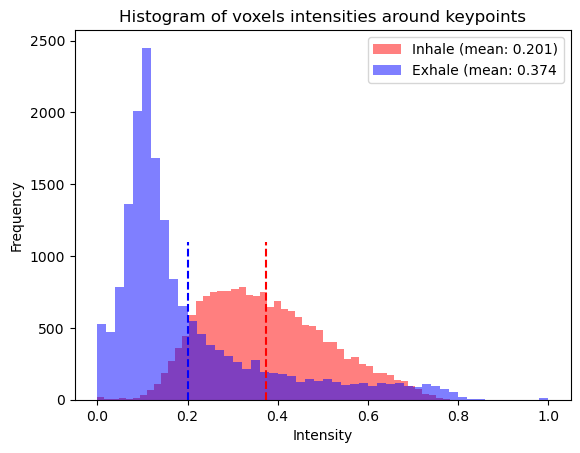

In [6]:
from tools.utils import convert_nda_to_itk
print('fixed image: ', sample['img1_path'])
print('moving image: ', sample['img2_path'])
fixed_img     = sample['voxel1']
moving_img    = sample['voxel2']
fixed_img_ct  = sample['img1']
moving_img_ct = sample['img2']
fixed_image   = convert_nda_to_itk(convert_tensor_to_numpy(fixed_img), fixed_img_ct)#sitk.ReadImage(sample['img1_path'])
moving_image  = convert_nda_to_itk(convert_tensor_to_numpy(moving_img), moving_img_ct)#sitk.ReadImage(sample['img2_path'])
mov_voxels = []
fix_voxels = []


for p in fixed_kps:
    fix_voxels.extend(fixed_image[int(p[0])-1:int(p[0])+1, int(p[1])-1:int(p[1])+1, int(p[2])-1:int(p[2])+1])
for p in moving_kps:
    mov_voxels.extend(moving_image[int(p[0])-1:int(p[0])+1, int(p[1])-1:int(p[1])+1, int(p[2])-1:int(p[2])+1])

mov_voxels = np.asarray(mov_voxels)
fix_voxels = np.asarray(fix_voxels)

# for p in moving_kps:
#     moving_image.SetPixel(int(p[0]), int(p[1]), int(p[2]), 1)
plt.hist(fix_voxels, bins=50, alpha=0.5, color='r')
plt.hist(mov_voxels, bins=50, alpha=0.5, color='b')
plt.legend([ f'Inhale (mean: {mov_voxels.mean():.3f})', f'Exhale (mean: {fix_voxels.mean():.3f}',])

plt.vlines(fix_voxels.mean(), 0, 1100, colors='r', linestyles='dashed')
plt.vlines(mov_voxels.mean(), 0, 1100, colors='b', linestyles='dashed')
plt.title('Histogram of voxels intensities around keypoints')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.show()

#fixed_image_a  = convert_itk_to_nda(convert_nda_to_itk(convert_tensor_to_numpy(fixed_img), fixed_img_ct))
#moving_image_a  = convert_itk_to_nda(convert_nda_to_itk(convert_tensor_to_numpy(moving_img), moving_img_ct))

moving_l.max() 2741.0
fixed_l.max() 1425.0


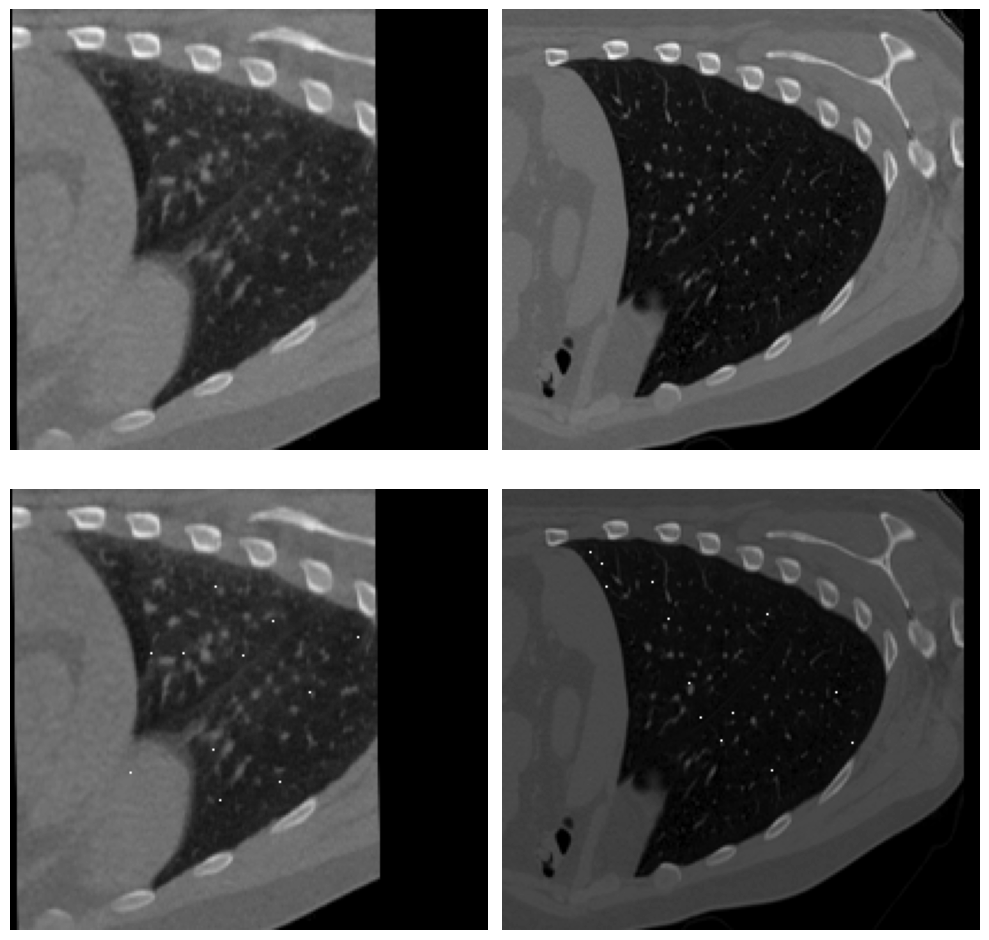

In [7]:
import SimpleITK as sitk
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# sitk -> xyz
# numpy -> zyx
fixed_image_a  = sitk.GetArrayFromImage(sample['img1']).T
moving_image_a = sitk.GetArrayFromImage(sample['img2']).T

fixed_l  = fixed_image_a.copy()
moving_l = moving_image_a.copy()

# moving_l[moving_kps] = moving_l.max()
# fixed_l[fixed_kps] = fixed_l.max()

for p in fixed_kps:
    moving_l[p[0], p[1], p[2]] = moving_l.max()

print('moving_l.max()', moving_l.max())
for p in moving_kps:
    fixed_l[p[0], p[1], p[2]] = fixed_l.max()
print('fixed_l.max()', fixed_l.max())

s = 40
axs[0,0].imshow(fixed_image_a[s, :, :], cmap='gray')
axs[0,0].axis('off')
axs[0, 1].imshow(moving_image_a[s, :, :], cmap='gray')
axs[0,1].axis('off')
axs[1,0].imshow(fixed_l[s, :, :], cmap='gray')
axs[1,0].axis('off')
axs[1,1].imshow(moving_l[s, :, :], cmap='gray')
axs[1,1].axis('off')
plt.tight_layout()
plt.show()

len fixed_kps 2191
len moving_kps 2191


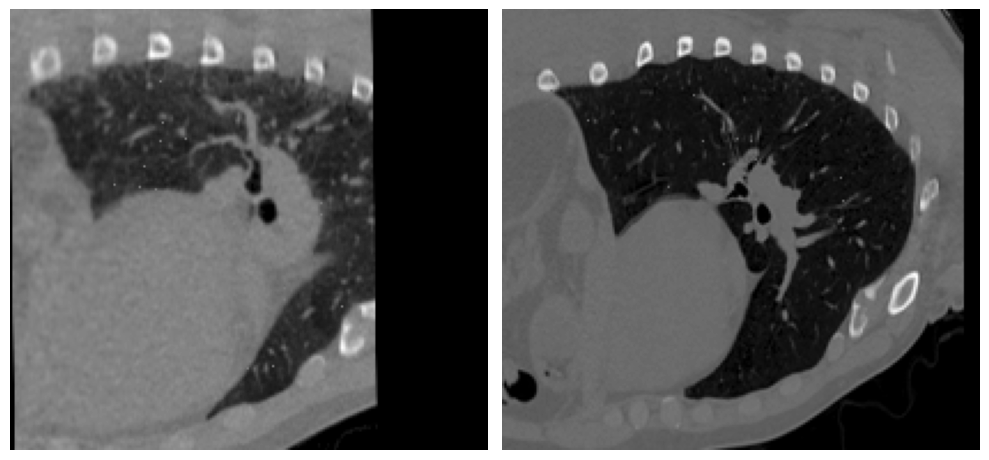

In [24]:
fixed_image  = sitk.ReadImage(sample['img1_path'])
moving_image = sitk.ReadImage(sample['img2_path'])

# sitk -> xyz
# numpy -> zyx
# moving_l[moving_kps] = moving_l.max()
# fixed_l[fixed_kps] = fixed_l.max()
print('len fixed_kps', len(fixed_kps))
for p in fixed_kps:
    moving_image.SetPixel(int(p[0]), int(p[1]), int(p[2]), 1)

print('len moving_kps', len(moving_kps))
for p in moving_kps:
    fixed_image.SetPixel(int(p[0]), int(p[1]), int(p[2]), 1)



moving_l = sitk.GetArrayFromImage(moving_image)
fixed_l  = sitk.GetArrayFromImage(fixed_image)
s = 70


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(fixed_l.T[s, :, :], cmap='gray')
axs[0].axis('off')
axs[1].imshow(moving_l.T[s, :, :], cmap='gray')
axs[1].axis('off')
plt.tight_layout()
plt.show()

In [9]:
'''import SimpleITK as sitk
from tools.utils import convert_itk_to_nda

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# sitk -> xyz
# numpy -> zyx
moving_image_a = convert_itk_to_nda(moving_img)#sitk.GetArrayFromImage(moving_img).T
fixed_image_a  = convert_itk_to_nda(fixed_img)#sitk.GetArrayFromImage(fixed_img).T

moving_l = moving_image_a.copy()
fixed_l  = fixed_image_a.copy()

# moving_l[moving_kps] = moving_l.max()
# fixed_l[fixed_kps] = fixed_l.max()
print('Heyyyy:' , fixed_kps)
for p in fixed_kps:
    moving_l[p[0], p[1], p[2]] = moving_l.max()

print('moving_l.max()', moving_l.max())
for p in moving_kps:
    fixed_l[p[0], p[1], p[2]] = fixed_l.max()
print('fixed_l.max()', fixed_l.max())

s = 150
axs[0,0].imshow(fixed_image_a[:, s, ], cmap='gray')
axs[0,0].axis('off')
axs[0, 1].imshow(moving_image_a[:, s, ], cmap='gray')
axs[0,1].axis('off')
axs[1,0].imshow(fixed_l[:, s, ], cmap='gray')
axs[1,0].axis('off')
axs[1,1].imshow(moving_l[:, s, ], cmap='gray')
axs[1,1].axis('off')
plt.tight_layout()
plt.show()'''

"import SimpleITK as sitk\nfrom tools.utils import convert_itk_to_nda\n\nfig, axs = plt.subplots(2, 2, figsize=(10, 10))\n# sitk -> xyz\n# numpy -> zyx\nmoving_image_a = convert_itk_to_nda(moving_img)#sitk.GetArrayFromImage(moving_img).T\nfixed_image_a  = convert_itk_to_nda(fixed_img)#sitk.GetArrayFromImage(fixed_img).T\n\nmoving_l = moving_image_a.copy()\nfixed_l  = fixed_image_a.copy()\n\n# moving_l[moving_kps] = moving_l.max()\n# fixed_l[fixed_kps] = fixed_l.max()\nprint('Heyyyy:' , fixed_kps)\nfor p in fixed_kps:\n    moving_l[p[0], p[1], p[2]] = moving_l.max()\n\nprint('moving_l.max()', moving_l.max())\nfor p in moving_kps:\n    fixed_l[p[0], p[1], p[2]] = fixed_l.max()\nprint('fixed_l.max()', fixed_l.max())\n\ns = 150\naxs[0,0].imshow(fixed_image_a[:, s, ], cmap='gray')\naxs[0,0].axis('off')\naxs[0, 1].imshow(moving_image_a[:, s, ], cmap='gray')\naxs[0,1].axis('off')\naxs[1,0].imshow(fixed_l[:, s, ], cmap='gray')\naxs[1,0].axis('off')\naxs[1,1].imshow(moving_l[:, s, ], cmap='gray

In [10]:
'''CHECK IT AGAIN
from tools.utils import convert_nda_to_itk
fixed_img_ct  = sample['img1']
moving_img_ct = sample['img2']
fixed_img  = sample['voxel1']
moving_img = sample['voxel2']
fixed_image_a  = convert_itk_to_nda(convert_nda_to_itk(convert_tensor_to_numpy(fixed_img), fixed_img_ct))
moving_image_a  = convert_itk_to_nda(convert_nda_to_itk(convert_tensor_to_numpy(moving_img), moving_img_ct))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))


# sitk -> xyz
# numpy -> zyx
#moving_image_a = sitk.GetArrayFromImage(moving_img).T
#fixed_image_a  = sitk.GetArrayFromImage(fixed_img).T

moving_l = moving_image_a.copy()
fixed_l  = fixed_image_a.copy()

# moving_l[moving_kps] = moving_l.max()
# fixed_l[fixed_kps] = fixed_l.max()

for p in fixed_kps:
    moving_l[p[0], p[1], p[2]] = moving_l.max()

print('moving_l.max()', moving_l.max())
for p in moving_kps:
    fixed_l[p[0], p[1], p[2]] = fixed_l.max()
print('fixed_l.max()', fixed_l.max())

s = 150
axs[0,0].imshow(fixed_image_a[: , :, s], cmap='gray')
axs[0,0].axis('off')
axs[0, 1].imshow(moving_image_a[:, :, s], cmap='gray')
axs[0,1].axis('off')
axs[1,0].imshow(fixed_l[:, :, s], cmap='gray')
axs[1,0].axis('off')
axs[1,1].imshow(moving_l[:, :, s], cmap='gray')
axs[1,1].axis('off')
plt.tight_layout()
plt.show()'''

"CHECK IT AGAIN\nfrom tools.utils import convert_nda_to_itk\nfixed_img_ct  = sample['img1']\nmoving_img_ct = sample['img2']\nfixed_img  = sample['voxel1']\nmoving_img = sample['voxel2']\nfixed_image_a  = convert_itk_to_nda(convert_nda_to_itk(convert_tensor_to_numpy(fixed_img), fixed_img_ct))\nmoving_image_a  = convert_itk_to_nda(convert_nda_to_itk(convert_tensor_to_numpy(moving_img), moving_img_ct))\n\nfig, axs = plt.subplots(2, 2, figsize=(10, 10))\n\n\n# sitk -> xyz\n# numpy -> zyx\n#moving_image_a = sitk.GetArrayFromImage(moving_img).T\n#fixed_image_a  = sitk.GetArrayFromImage(fixed_img).T\n\nmoving_l = moving_image_a.copy()\nfixed_l  = fixed_image_a.copy()\n\n# moving_l[moving_kps] = moving_l.max()\n# fixed_l[fixed_kps] = fixed_l.max()\n\nfor p in fixed_kps:\n    moving_l[p[0], p[1], p[2]] = moving_l.max()\n\nprint('moving_l.max()', moving_l.max())\nfor p in moving_kps:\n    fixed_l[p[0], p[1], p[2]] = fixed_l.max()\nprint('fixed_l.max()', fixed_l.max())\n\ns = 150\naxs[0,0].imshow